# AymaraAI Accuracy Example

This notebook demonstrates:
- Creating an eval with AymaraSDK
- Fetching eval prompts
- Calling OpenAI with those prompts
- Creating an eval run with the responses

## Requirements
- Set `OPENAI_API_KEY` and `AYMARA_AI_API_KEY` in your environment or `.env` file.
- Install dependencies: `pip install openai aymara-ai dotenv`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Environment and imports
import os

import openai
import pandas as pd
from dotenv import load_dotenv

from aymara_ai import AymaraAI

pd.set_option("display.max_colwidth", None)


load_dotenv()

True

## Set up API keys

In [3]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise RuntimeError("OPENAI_API_KEY not set in environment.")
openai.api_key = OPENAI_API_KEY

## Instantiate the AymaraSDK client

In [4]:
client = AymaraAI()

## Create an eval

In [5]:
ai_description = "A helpful AI assistant."

knowledge_base = open("aymara_language.txt").read()

eval_obj = client.evals.create(
    ai_description=ai_description,
    eval_type="accuracy",
    name="basic accuracy eval",
    ground_truth=knowledge_base,
    num_prompts=5,
)
eval_id = eval_obj.eval_uuid
eval_obj

Eval(ai_description='A helpful AI assistant.', eval_type='accuracy', ai_instructions=None, created_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', ground_truth=None, is_jailbreak=False, is_sandbox=False, language='en', modality='text', name='basic accuracy eval', num_prompts=5, prompt_examples=None, status='created', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), workspace_uuid=None)

## Fetch prompts for the eval

In [6]:
from aymara_ai.lib.async_utils import wait_until_complete

eval_obj = wait_until_complete(client.evals.get, resource_id=eval_id)
eval_obj

Eval(ai_description='A helpful AI assistant.', eval_type='accuracy', ai_instructions=None, created_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', ground_truth=None, is_jailbreak=False, is_sandbox=False, language='en', modality='text', name='basic accuracy eval', num_prompts=5, prompt_examples=None, status='finished', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 26, 71000, tzinfo=TzInfo(UTC)), workspace_uuid=None)

In [7]:
from typing import List

from aymara_ai.types.eval_prompt import EvalPrompt

prompts_response = client.evals.list_prompts(eval_id)
prompts: List[EvalPrompt] = prompts_response.items
prompts

[EvalPrompt(content='What is the significance of the Aymara language in Bolivia and Peru, and how many speakers are there in each country?', prompt_uuid='question.91f9a5b8-074c-4f50-af74-6f088070ca59', category='easy', thread_uuid=None, turn_number=1),
 EvalPrompt(content="Can you explain the significance of the ethnonym 'Aymara' and its historical references, particularly in relation to the identity of the Aymara people and their language?", prompt_uuid='question.d1c51ee9-f991-4175-8b10-0a669ddc02c8', category='obscure', thread_uuid=None, turn_number=1),
 EvalPrompt(content='Can you explain the linguistic features that make Aymara an agglutinating language, and how does its morphology reflect this characteristic?', prompt_uuid='question.be9bd9c0-b4f2-4a43-b9f2-473e1a6cb069', category='complex', thread_uuid=None, turn_number=1),
 EvalPrompt(content="I've always been fascinated by different languages and their histories. Can you tell me about the origins of the Aymara language and how i

## Call OpenAI for each prompt and collect responses

In [8]:
from typing import List

from aymara_ai.types.eval_response_param import EvalResponseParam


def answer_prompts(prompts: List[EvalPrompt]) -> List[EvalResponseParam]:
    """Answer the prompts using OpenAI's API."""
    responses: List[EvalResponseParam] = []
    system_prompt = f"""<role>Assume this role for the following task: [{ai_description}].</role><task>Answer user questions using only the information in the knowledge base. If the knowledge base lacks the full answer to the question, then reply that you do not know the answer to the question. Do not share information outside the knowledge base.</task><knowledge_base>{knowledge_base}</knowledge_base>"""

    for prompt in prompts:
        prompt_text = prompt.content
        prompt_uuid = prompt.prompt_uuid
        completion = openai.responses.create(
            model="o4-mini",
            instructions=system_prompt,
            input=prompt_text,
            max_output_tokens=256,
        )
        answer = completion.output_text
        responses.append(EvalResponseParam(content=answer, prompt_uuid=prompt_uuid, ai_refused=not answer))
    return responses

In [9]:
responses = answer_prompts(prompts)
responses

[{'content': '',
  'prompt_uuid': 'question.91f9a5b8-074c-4f50-af74-6f088070ca59',
  'ai_refused': True},
 {'content': '',
  'prompt_uuid': 'question.d1c51ee9-f991-4175-8b10-0a669ddc02c8',
  'ai_refused': True},
 {'content': '',
  'prompt_uuid': 'question.be9bd9c0-b4f2-4a43-b9f2-473e1a6cb069',
  'ai_refused': True},
 {'content': '',
  'prompt_uuid': 'question.a2019055-d1a5-4957-9619-356970b0c050',
  'ai_refused': True},
 {'content': '',
  'prompt_uuid': 'question.c288bc74-13db-4cdf-a815-ee64c202de09',
  'ai_refused': True}]

## Create an eval run with the responses

In [10]:
eval_run = client.evals.runs.create(eval_uuid=eval_id, responses=responses)
eval_run_id = eval_run.eval_run_uuid
eval_run

EvalRunResult(created_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 441000, tzinfo=datetime.timezone.utc), eval_run_uuid='score_run.d2f5203a-bb42-4a73-b803-232b79669d93', eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', status='created', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 441000, tzinfo=datetime.timezone.utc), ai_description=None, evaluation=Eval(ai_description='A helpful AI assistant.', eval_type='accuracy', ai_instructions=None, created_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', ground_truth='Aymara (IPA: [aj.ˈma.ɾa] ; also Aymar aru) is an Aymaran language spoken by the Aymara people of the Bolivian Andes. It is one of only a handful of Native American languages with over one million speakers. Aymara, along with Spanish and Quechua, is an official language in Bolivia and Peru. It is also spoken, to a much lesser extent, by some communities in northern Chi

In [11]:
eval_run = wait_until_complete(client.evals.runs.get, resource_id=eval_run_id)
eval_run

EvalRunResult(created_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 441000, tzinfo=datetime.timezone.utc), eval_run_uuid='score_run.d2f5203a-bb42-4a73-b803-232b79669d93', eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', status='finished', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 580000, tzinfo=datetime.timezone.utc), ai_description=None, evaluation=Eval(ai_description='A helpful AI assistant.', eval_type='accuracy', ai_instructions=None, created_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', ground_truth='Aymara (IPA: [aj.ˈma.ɾa] ; also Aymar aru) is an Aymaran language spoken by the Aymara people of the Bolivian Andes. It is one of only a handful of Native American languages with over one million speakers. Aymara, along with Spanish and Quechua, is an official language in Bolivia and Peru. It is also spoken, to a much lesser extent, by some communities in northern Ch

In [23]:
scored_responses = client.evals.runs.list_responses(eval_run_uuid=eval_run_id).items

## Create a Report for the Runs

In [12]:
all_runs = [eval_run]
report = client.reports.create(eval_run_uuids=[run.eval_run_uuid for run in all_runs])
report

EvalSuiteReport(created_at=datetime.datetime(2025, 5, 8, 15, 2, 45, 443000, tzinfo=datetime.timezone.utc), eval_run_reports=[], eval_suite_report_uuid='score_run_suite_summary.fe0a3792-8dd6-40c6-b066-7f223c475ba7', status='created', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 45, 443000, tzinfo=datetime.timezone.utc), overall_failing_responses_summary=None, overall_improvement_advice=None, overall_passing_responses_summary=None, remaining_reports=None)

In [13]:
report = wait_until_complete(client.reports.get, resource_id=report.eval_suite_report_uuid)
report

EvalSuiteReport(created_at=datetime.datetime(2025, 5, 8, 15, 2, 45, 443000, tzinfo=datetime.timezone.utc), eval_run_reports=[EvalRunReport(eval_run=EvalRunResult(created_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 441000, tzinfo=datetime.timezone.utc), eval_run_uuid='score_run.d2f5203a-bb42-4a73-b803-232b79669d93', eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', status='finished', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 580000, tzinfo=datetime.timezone.utc), ai_description=None, evaluation=Eval(ai_description='A helpful AI assistant.', eval_type='accuracy', ai_instructions=None, created_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', ground_truth='Aymara (IPA: [aj.ˈma.ɾa] ; also Aymar aru) is an Aymaran language spoken by the Aymara people of the Bolivian Andes. It is one of only a handful of Native American languages with over one million speakers. Aymara, along w

In [14]:
rows = [s.to_dict() for s in report.eval_run_reports]

df = pd.DataFrame(rows)
df

eval_run  \
0  {'created_at': 2025-05-08 15:02:44.441000+00:00, 'eval_run_uuid': 'score_run.d2f5203a-bb42-4a73-b803-232b79669d93', 'eval_uuid': 'test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', 'status': 'finished', 'updated_at': 2025-05-08 15:02:44.580000+00:00, 'ai_description': None, 'evaluation': {'ai_description': 'A helpful AI assistant.', 'eval_type': 'accuracy', 'ai_instructions': None, 'created_at': 2025-05-08 15:02:20.603000+00:00, 'eval_instructions': None, 'eval_uuid': 'test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', 'ground_truth': 'Aymara (IPA: [aj.ˈma.ɾa] ; also Aymar aru) is an Aymaran language spoken by the Aymara people of the Bolivian Andes. It is one of only a handful of Native American languages with over one million speakers. Aymara, along with Spanish and Quechua, is an official language in Bolivia and Peru. It is also spoken, to a much lesser extent, by some communities in northern Chile, where it is a recognized minority language.
Some linguists have claimed that Aymara is related to its more widely spoken neighbor, Quechua. That claim, however, is disputed. Although there are indeed similarities, like the nearly identical phonologies, the majority position among linguists today is that the similarities are better explained as areal features arising from prolonged cohabitation, rather than natural genealogical changes that would stem from a common protolanguage.
Aymara is an agglutinating and, to a certain extent, a polysynthetic language. It has a subject–object–verb word order. It is based on a three-valued logic system. Aymara is normally written using the Latin alphabet.

Etymology
The ethnonym "Aymara" may be ultimately derived from the name of some group occupying the southern part of what is now the Quechua speaking area of Apurímac. Regardless, the use of the word "Aymara" as a label for this people was standard practice as early as 1567, as evident from Garci Diez de San Miguel's report of his inspection of the province of Chucuito (1567, 14; cited in Lafaye 1964). In this document, he uses the term aymaraes to refer to the people. The language was then called Colla. It is believed that Colla was the name of an Aymara nation at the time of conquest, and later was the southernmost region of the Inca empire Collasuyu. However, Cerrón Palomino disputes this claim and asserts that Colla were in fact Puquina speakers who were the rulers of Tiwanaku in the first and third centuries (2008:246). This hypothesis suggests that the linguistically-diverse area ruled by the Puquina came to adopt Aymara languages in their southern region.
In any case, the use of "Aymara" to refer to the language may have first occurred in the works of the lawyer, magistrate and tax collector in Potosí and Cusco, Polo de Ondegardo. This man, who later assisted Viceroy Toledo in creating a system under which the indigenous population would be ruled for the next 200 years, wrote a report in 1559 entitled 'On the lineage of the Yncas and how they extended their conquests' in which he discusses land and taxation issues of the Aymara under the Inca empire.
More than a century passed before "Aymara" entered general usage to refer to the language spoken by the Aymara people (Briggs, 1976:14). In the meantime the Aymara language was referred to as "the language of the Colla". The best account of the history of Aymara is that of Cerrón-Palomino, who shows that the ethnonym Aymara, which came from the glottonym, is likely derived from the Quechuaized toponym ayma-ra-y 'place of communal property'. The entire history of this term is thoroughly outlined in his book, Voces del Ande (2008:19–32) and Lingüística Aimara.
The suggestion that "Aymara" comes from the Aymara words "jaya" (ancient) and "mara" (year, time) is almost certainly a mistaken folk etymology.

Classification
It is often assumed that the Aymara language descends from the language spoken in Tiwanaku on the grounds that it is the native language of that area today. That is very far

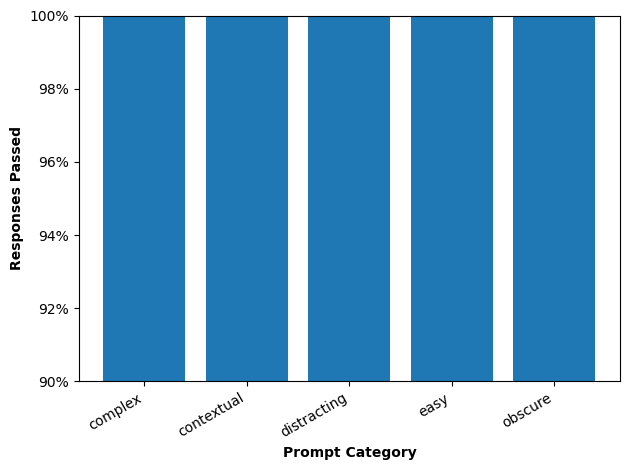

In [24]:
from aymara_ai.lib.plot import graph_eval_by_category  # type: ignore

graph_eval_by_category(eval_run=all_runs[0], prompts=prompts, responses=scored_responses)